In [1]:
!pip install tensorflow==2.15.0 tensorflow-quantum==0.7.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: sympy
    Found existing installation: sy

In [2]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<ipython-input-2-b07882b7b3a0>:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import importlib, pkg_resources


<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

In [3]:
import cirq
import sympy
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
np.random.seed(1234)

## 1. Data preparation

1.1 Download fashion-MNIST

In [140]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [141]:
def filter_03(x, y):
    keep = (y == 0) | (y == 3)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

In [142]:
x_train, y_train = filter_03(x_train, y_train)
x_test, y_test = filter_03(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12000
Number of filtered test examples: 2000


True


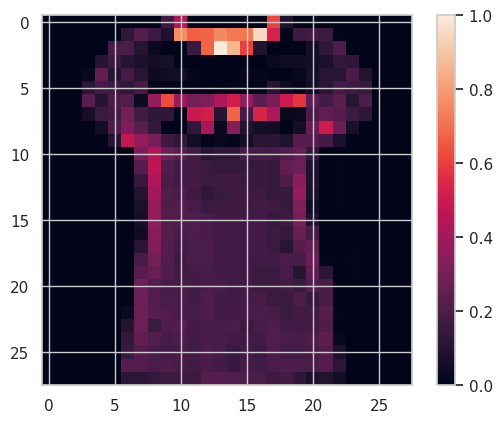

In [143]:
print(y_train[10])

plt.imshow(x_train[10, :, :])
plt.colorbar()

### 1.2 Downscale the images

In [144]:
def truncate_x(x_train, x_test, n_components=10):
  """Perform PCA on image dataset keeping the top `n_components` components."""
  n_points_train = tf.gather(tf.shape(x_train), 0)
  n_points_test = tf.gather(tf.shape(x_test), 0)

  # Flatten to 1D
  x_train = tf.reshape(x_train, [n_points_train, -1])
  x_test = tf.reshape(x_test, [n_points_test, -1])

  # Normalize.
  feature_mean = tf.reduce_mean(x_train, axis=0)
  x_train_normalized = x_train - feature_mean
  x_test_normalized = x_test - feature_mean

  # Truncate.
  e_values, e_vectors = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_train_normalized, x_train_normalized))
  return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]), \
    tf.einsum('ij,jk->ik', x_test_normalized, e_vectors[:, -n_components:])

In [145]:
DATASET_DIM = 10
x_train, x_test = truncate_x(x_train, x_test, n_components=DATASET_DIM)
print(f'New datapoint dimension:', len(x_train[0]))

New datapoint dimension: 10


In [146]:
N_TRAIN = 1000
N_TEST = 200
x_train, x_test = x_train[:N_TRAIN], x_test[:N_TEST]
y_train, y_test = y_train[:N_TRAIN], y_test[:N_TEST]

In [147]:
print("New number of training examples:", len(x_train))
print("New number of test examples:", len(x_test))

New number of training examples: 1000
New number of test examples: 200


## 2. Relabeling and computing PQK features

### 2.1 Quantum encoding and PQK features

In [12]:
def single_qubit_wall(qubits, rotations):
  """Prepare a single qubit X,Y,Z rotation wall on `qubits`."""
  wall_circuit = cirq.Circuit()
  for i, qubit in enumerate(qubits):
    for j, gate in enumerate([cirq.X, cirq.Y, cirq.Z]):
      wall_circuit.append(gate(qubit) ** rotations[i][j])

  return wall_circuit

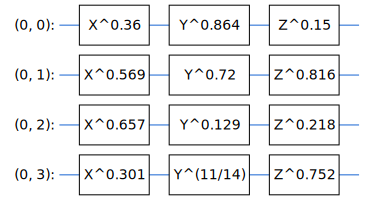

In [148]:
SVGCircuit(single_qubit_wall(
    cirq.GridQubit.rect(1,4), np.random.uniform(size=(4, 3))))

In [149]:
def v_theta(qubits):
  """Prepares a circuit that generates V(\theta)."""
  ref_paulis = [
      cirq.X(q0) * cirq.X(q1) + \
      cirq.Y(q0) * cirq.Y(q1) + \
      cirq.Z(q0) * cirq.Z(q1) for q0, q1 in zip(qubits, qubits[1:])
  ]
  exp_symbols = list(sympy.symbols('ref_0:'+str(len(ref_paulis))))
  return tfq.util.exponential(ref_paulis, exp_symbols), exp_symbols

Symbols found in circuit:[ref_0]


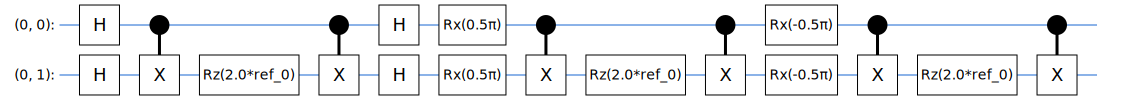

In [150]:
test_circuit, test_symbols = v_theta(cirq.GridQubit.rect(1, 2))
print(f'Symbols found in circuit:{test_symbols}')
SVGCircuit(test_circuit)

In [151]:
def prepare_pqk_circuits(qubits, classical_source, n_trotter=10):
  """Prepare the pqk feature circuits around a dataset."""
  n_qubits = len(qubits)
  n_points = len(classical_source)

  # Prepare random single qubit rotation wall.
  random_rots = np.random.uniform(-2, 2, size=(n_qubits, 3))
  initial_U = single_qubit_wall(qubits, random_rots)

  # Prepare parametrized V
  V_circuit, symbols = v_theta(qubits)
  exp_circuit = cirq.Circuit(V_circuit for t in range(n_trotter))

  # Convert to `tf.Tensor`
  initial_U_tensor = tfq.convert_to_tensor([initial_U])
  initial_U_splat = tf.tile(initial_U_tensor, [n_points])

  full_circuits = tfq.layers.AddCircuit()(
      initial_U_splat, append=exp_circuit)
  # Replace placeholders in circuits with values from `classical_source`.
  return tfq.resolve_parameters(
      full_circuits, tf.convert_to_tensor([str(x) for x in symbols]),
      tf.convert_to_tensor(classical_source*(n_qubits/3)/n_trotter))

In [152]:
qubits = cirq.GridQubit.rect(1, DATASET_DIM + 1)
q_x_train_circuits = prepare_pqk_circuits(qubits, x_train)
q_x_test_circuits = prepare_pqk_circuits(qubits, x_test)

In [153]:
def get_pqk_features(qubits, data_batch):
  """Get PQK features based on above construction."""
  ops = [[cirq.X(q), cirq.Y(q), cirq.Z(q)] for q in qubits]
  ops_tensor = tf.expand_dims(tf.reshape(tfq.convert_to_tensor(ops), -1), 0)
  batch_dim = tf.gather(tf.shape(data_batch), 0)
  ops_splat = tf.tile(ops_tensor, [batch_dim, 1])
  exp_vals = tfq.layers.Expectation()(data_batch, operators=ops_splat)
  rdm = tf.reshape(exp_vals, [batch_dim, len(qubits), -1])
  return rdm

In [154]:
x_train_pqk = get_pqk_features(qubits, q_x_train_circuits)
x_test_pqk = get_pqk_features(qubits, q_x_test_circuits)
print('New PQK training dataset has shape:', x_train_pqk.shape)
print('New PQK testing dataset has shape:', x_test_pqk.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


New PQK training dataset has shape: (1000, 11, 3)
New PQK testing dataset has shape: (200, 11, 3)


### 2.2 Re-labeling based on PQK features

In [155]:
def compute_kernel_matrix(vecs, gamma):
  """Computes d[i][j] = e^ -gamma * (vecs[i] - vecs[j]) ** 2 """
  scaled_gamma = gamma / (
      tf.cast(tf.gather(tf.shape(vecs), 1), tf.float32) * tf.math.reduce_std(vecs))
  return scaled_gamma * tf.einsum('ijk->ij',(vecs[:,None,:] - vecs) ** 2)

def get_spectrum(datapoints, gamma=1.0):
  """Compute the eigenvalues and eigenvectors of the kernel of datapoints."""
  KC_qs = compute_kernel_matrix(datapoints, gamma)
  S, V = tf.linalg.eigh(KC_qs)
  S = tf.math.abs(S)
  return S, V

In [156]:
S_pqk, V_pqk = get_spectrum(
    tf.reshape(tf.concat([x_train_pqk, x_test_pqk], 0), [-1, len(qubits) * 3]))

S_original, V_original = get_spectrum(
    tf.cast(tf.concat([x_train, x_test], 0), tf.float32), gamma=0.005)

print('Eigenvectors of pqk kernel matrix:', V_pqk)
print('Eigenvectors of original kernel matrix:', V_original)

Eigenvectors of pqk kernel matrix: tf.Tensor(
[[ 2.4820656e-02 -2.2936581e-02 -3.6381602e-03 ...  1.7549269e-02
   1.0129879e-02  2.3370871e-02]
 [ 2.3733661e-02  5.8955688e-02  2.5406960e-02 ...  1.4254511e-02
   1.5861899e-02  3.0193355e-02]
 [ 2.3863420e-02  1.7549461e-02 -3.3168893e-04 ...  1.7767899e-02
  -1.9633137e-02  2.6156815e-02]
 ...
 [-7.2311223e-02  2.4703212e-02 -3.6880001e-04 ...  4.1235074e-01
  -3.0914631e-01  5.1924229e-02]
 [-7.0910394e-02 -3.0781943e-03  6.3624624e-03 ...  3.0470765e-01
   2.6660234e-01  4.9603939e-02]
 [-4.4472847e-02  9.5482599e-03 -1.9943032e-02 ...  0.0000000e+00
   0.0000000e+00  3.4026135e-02]], shape=(1200, 1200), dtype=float32)
Eigenvectors of original kernel matrix: tf.Tensor(
[[ 0.03835682 -0.0283473  -0.01169783 ... -0.00157049 -0.03562555
   0.03206971]
 [-0.04018167 -0.00888094 -0.01388247 ... -0.02960675  0.01823647
   0.0288196 ]
 [-0.01667189 -0.01350371 -0.0366386  ... -0.02697806  0.01625295
   0.02195407]
 ...
 [-0.03015643  0.01

In [157]:
def get_stilted_dataset(S, V, S_2, V_2, lambdav=1.1):
  """Prepare new labels that maximize geometric distance between kernels."""
  S_diag = tf.linalg.diag(S ** 0.5)
  S_2_diag = tf.linalg.diag(S_2 / (S_2 + lambdav) ** 2)
  scaling = S_diag @ tf.transpose(V) @ \
            V_2 @ S_2_diag @ tf.transpose(V_2) @ \
            V @ S_diag

  # Generate new lables using the largest eigenvector.
  _, vecs = tf.linalg.eig(scaling)
  new_labels = tf.math.real(
      tf.einsum('ij,j->i', tf.cast(V @ S_diag, tf.complex64), vecs[-1])).numpy()
  # Create new labels and add some small amount of noise.
  final_y = new_labels > np.median(new_labels)
  noisy_y = (final_y ^ (np.random.uniform(size=final_y.shape) > 0.95))
  return noisy_y

In [158]:
y_relabel = get_stilted_dataset(S_pqk, V_pqk, S_original, V_original)
y_train_new, y_test_new = y_relabel[:N_TRAIN], y_relabel[N_TRAIN:]

## 3. Comparing models

### 3.1 Enhanced PQK model

In [24]:
#docs_infra: no_execute
def create_pqk_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[len(qubits) * 3,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

pqk_model = create_pqk_model()
pqk_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

pqk_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1088      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1633 (6.38 KB)
Trainable params: 1633 (6.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
#docs_infra: no_execute
pqk_history = pqk_model.fit(tf.reshape(x_train_pqk, [N_TRAIN, -1]),
          y_train_new,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(tf.reshape(x_test_pqk, [N_TEST, -1]), y_test_new))

Epoch 1/50
32/32 [==============================] - 2s 11ms/step - loss: 0.6809 - accuracy: 0.5750 - val_loss: 0.8649 - val_accuracy: 0.0300
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.5830 - val_loss: 0.7035 - val_accuracy: 0.0300
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.5830 - val_loss: 0.7440 - val_accuracy: 0.0300
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.5985 - accuracy: 0.5960 - val_loss: 0.6189 - val_accuracy: 0.2150
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.5562 - accuracy: 0.6610 - val_loss: 0.5031 - val_accuracy: 0.5350
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 0.5138 - accuracy: 0.7110 - val_loss: 0.3774 - val_accuracy: 0.7600
Epoch 7/50
32/32 [==============================] - 0s 5ms/step - loss: 0.4828 - accuracy: 0.7610 - val_loss: 0.3196 - val_accuracy: 0.8200
Epoch 8/50
32/32 [=

In [26]:
# Ensure the input data is reshaped correctly for the model
x_test_pqk_reshaped = tf.reshape(x_test_pqk, [len(x_test_pqk), -1])

# Now you can use the model to predict
predictions = pqk_model.predict(x_test_pqk_reshaped)


7/7 [==============================] - 0s 3ms/step


In [69]:
pqk_predictions = np.argmax(predictions)

In [27]:
test_loss, test_accuracy = pqk_model.evaluate(x_test_pqk_reshaped, y_test_new)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

7/7 [==============================] - 0s 3ms/step - loss: 0.1787 - accuracy: 0.9700
Test Loss: 0.1787349134683609
Test Accuracy: 0.9700000286102295


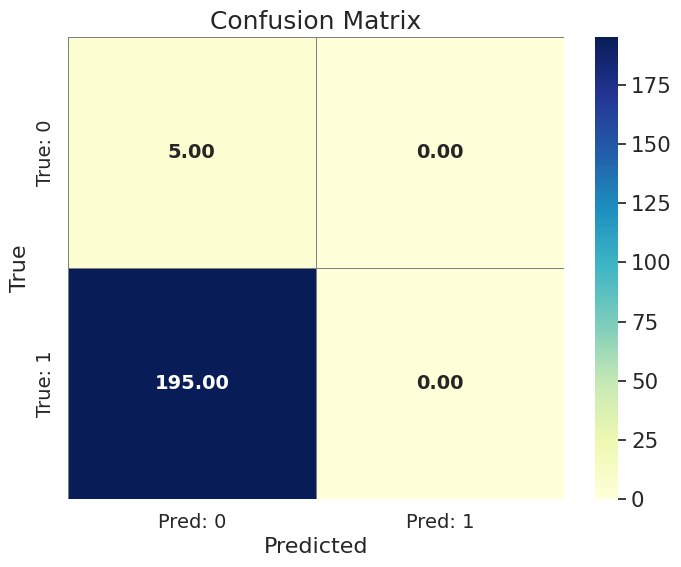

              precision    recall  f1-score   support

     Class 0       0.03      1.00      0.05         5
     Class 1       0.00      0.00      0.00       195

    accuracy                           0.03       200
   macro avg       0.01      0.50      0.02       200
weighted avg       0.00      0.03      0.00       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [118]:
predicted_labels = (predictions > 0.5).astype(int)

cm = confusion_matrix(y_test_new, predicted_labels)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="YlGnBu", annot_kws={"size": 14, "weight": 'bold'},
                 xticklabels=["Pred: 0", "Pred: 1"], yticklabels=["True: 0", "True: 1"], linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
report = classification_report(y_test_new, predicted_labels, target_names=["Class 0", "Class 1"])

print(report)

### 3.2 Create a classical model

In [159]:
#docs_infra: no_execute
def create_fair_classical_model():
    classic_model = tf.keras.Sequential()
    classic_model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[DATASET_DIM,]))
    classic_model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    classic_model.add(tf.keras.layers.Dense(1))
    return classic_model

classic_model = create_fair_classical_model()
classic_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              metrics=['accuracy'])

classic_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 32)                352       
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 897 (3.50 KB)
Trainable params: 897 (3.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [160]:
#docs_infra: no_execute
classical_history = classic_model.fit(x_train,
          y_train_new,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(x_test, y_test_new))

Epoch 1/50
32/32 [==============================] - 1s 17ms/step - loss: 0.6917 - accuracy: 0.5770 - val_loss: 0.8006 - val_accuracy: 0.0600
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.5830 - val_loss: 0.9507 - val_accuracy: 0.0600
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6709 - accuracy: 0.5820 - val_loss: 1.0200 - val_accuracy: 0.0600
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.5850 - val_loss: 0.9595 - val_accuracy: 0.0600
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.6672 - accuracy: 0.5910 - val_loss: 0.9735 - val_accuracy: 0.0750
Epoch 6/50
32/32 [==============================] - 0s 5ms/step - loss: 0.6605 - accuracy: 0.6110 - val_loss: 0.7540 - val_accuracy: 0.1200
Epoch 7/50
32/32 [==============================] - 0s 5ms/step - loss: 0.6586 - accuracy: 0.6140 - val_loss: 0.8892 - val_accuracy: 0.0900
Epoch 8/50
32/32 [=

In [161]:
classic_model.predict(np.expand_dims(x_test[0], axis=0)).round(2)

1/1 [==============================] - 0s 43ms/step


array([[-4.58]], dtype=float32)

In [162]:
np.argmax(classic_model.predict(np.expand_dims(x_test[0],axis=0)).round(2))

1/1 [==============================] - 0s 17ms/step


0

In [163]:
classic_model.evaluate(x_test,y_test)

7/7 [==============================] - 0s 4ms/step - loss: 1.4084 - accuracy: 0.4900


[1.4083852767944336, 0.49000000953674316]

### 3.3 Compare performance

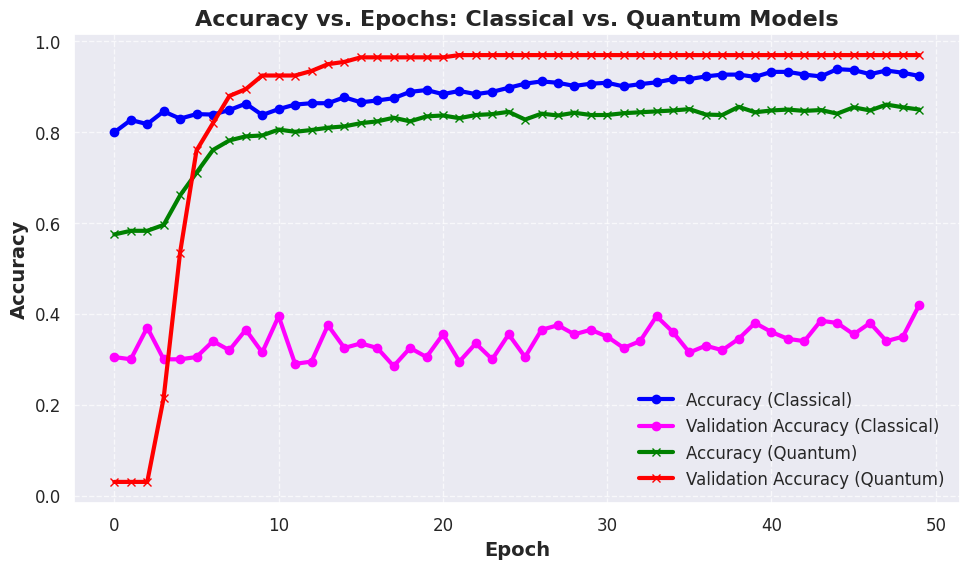

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(classical_history.history['accuracy'], label='Accuracy (Classical)', color='blue', linewidth=3, marker='o', markersize=6)
plt.plot(classical_history.history['val_accuracy'], label='Validation Accuracy (Classical)', color='magenta', linewidth=3, marker='o', markersize=6)
plt.plot(pqk_history.history['accuracy'], label='Accuracy (Quantum)', color='green', linewidth=3, marker='x', markersize=6)
plt.plot(pqk_history.history['val_accuracy'], label='Validation Accuracy (Quantum)', color='red', linewidth=3, marker='x', markersize=6)

plt.title('Accuracy vs. Epochs: Classical vs. Quantum Models', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=14, weight='bold')
plt.ylabel('Accuracy', fontsize=14, weight='bold')

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(fontsize=12, loc='lower right', frameon=False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


## 4. CNN Model

In [107]:
import tensorflow_datasets as tfds
dataset,metadata =tfds.load('fashion_mnist',as_supervised=True,with_info=True)
train_dataset,test_dataset=dataset['train'],dataset['test']

In [108]:
num_train_examples=metadata.splits['train'].num_examples
num_test_examples=metadata.splits['test'].num_examples

print("Number of training examples : {}".format(num_train_examples))
print("number of testing examples : {}".format(num_test_examples))

Number of training examples : 60000
number of testing examples : 10000


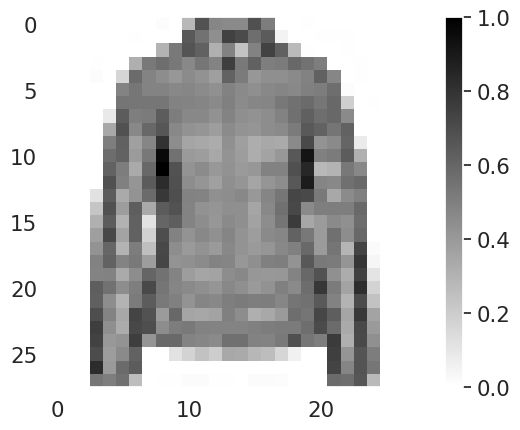

In [104]:
def Normalize(images,labels):
    images=tf.cast(images,tf.float32)
    images/=255
    return images,labels

train_dataset=train_dataset.map(Normalize)
test_dataset=test_dataset.map(Normalize)

train_dataset=train_dataset.cache()
test_dataset=test_dataset.cache()
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28, 28))


plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


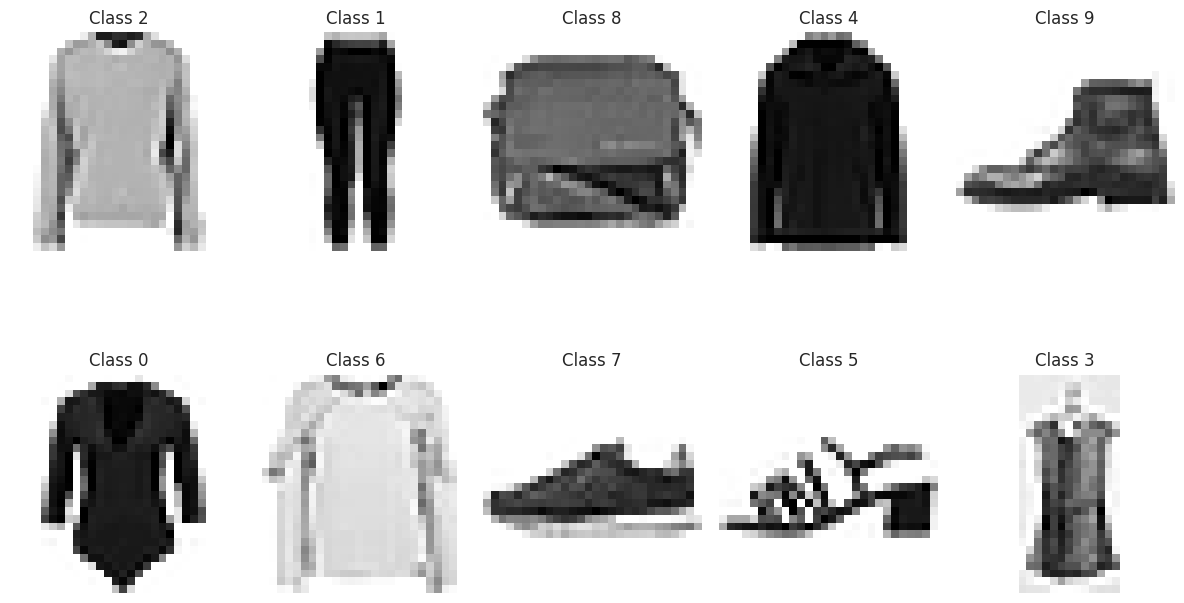

In [66]:
import matplotlib.pyplot as plt
class_images = {}

for image, label in train_dataset:
    label = label.numpy()
    if label not in class_images:
        class_images[label] = image
    if len(class_images) == 10:
        break

plt.figure(figsize=(12, 8))
for idx, (label, image) in enumerate(class_images.items()):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image.numpy().reshape(28, 28), cmap=plt.cm.binary)
    plt.title(f"Class {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [38]:
cnn_model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),padding='same',activation=tf.nn.relu,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.nn.relu,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation=tf.nn.relu),
   tf.keras.layers.Dense(10,activation=tf.nn.softmax)
])

In [39]:
cnn_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [126]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [40]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [41]:
CNN_history = cnn_model.fit(train_dataset,
          batch_size=32,
          epochs=50,
          steps_per_epoch=np.ceil(num_train_examples/BATCH_SIZE),
          verbose=0,
          validation_data=(test_dataset))

In [42]:
test_loss,test_accuracy=cnn_model.evaluate(test_dataset,steps=np.ceil(num_test_examples/32))
print(f'The loss on test dataset is :{test_loss}')
print(f'The accuracy on test dataset is :{test_accuracy}')

313/313 [==============================] - 1s 3ms/step - loss: 0.9838 - accuracy: 0.9138
The loss on test dataset is :0.9837612509727478
The accuracy on test dataset is :0.9138000011444092


313/313 [==============================] - 1s 2ms/step


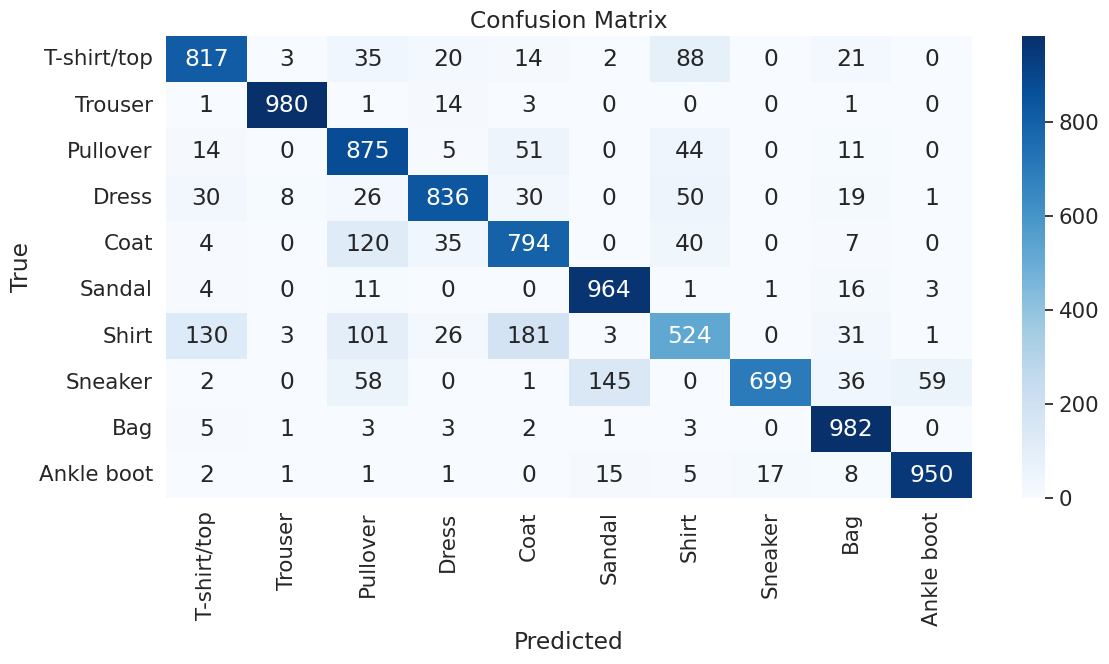

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.82      0.81      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.71      0.88      0.78      1000
       Dress       0.89      0.84      0.86      1000
        Coat       0.74      0.79      0.76      1000
      Sandal       0.85      0.96      0.91      1000
       Shirt       0.69      0.52      0.60      1000
     Sneaker       0.97      0.70      0.81      1000
         Bag       0.87      0.98      0.92      1000
  Ankle boot       0.94      0.95      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



In [109]:
class_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
BATCH_SIZE = 32
test_dataset = test_dataset.batch(BATCH_SIZE)

test_images = []
test_labels = []
for images, labels in test_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
y_pred_probs = cnn_model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true = []
for _, labels in test_dataset.unbatch():
    y_true.append(labels.numpy())
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(13, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

cr = classification_report(y_true, y_pred_labels, target_names=class_labels)
print(cr)

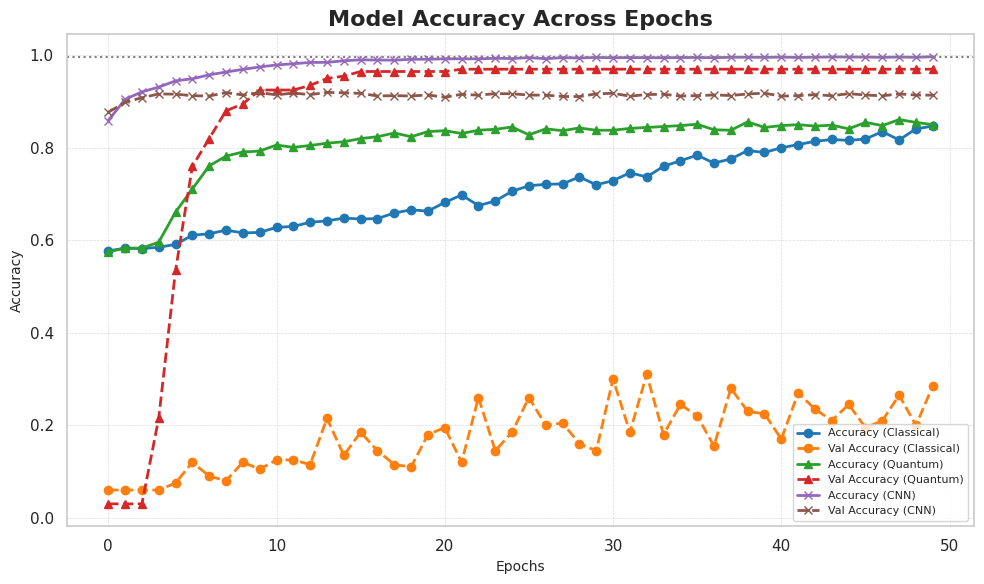

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
palette = sns.color_palette("tab10", n_colors=6)

plt.figure(figsize=(10, 6))

plt.plot(classical_history.history['accuracy'], label='Accuracy (Classical)',
         color=palette[0], linestyle='-', marker='o', linewidth=2)
plt.plot(classical_history.history['val_accuracy'], label='Val Accuracy (Classical)',
         color=palette[1], linestyle='--', marker='o', linewidth=2)
plt.plot(pqk_history.history['accuracy'], label='Accuracy (Quantum)',
         color=palette[2], linestyle='-', marker='^', linewidth=2)
plt.plot(pqk_history.history['val_accuracy'], label='Val Accuracy (Quantum)',
         color=palette[3], linestyle='--', marker='^', linewidth=2)
plt.plot(CNN_history.history['accuracy'], label='Accuracy (CNN)',
         color=palette[4], linestyle='-', marker='x', linewidth=2)
plt.plot(CNN_history.history['val_accuracy'], label='Val Accuracy (CNN)',
         color=palette[5], linestyle='--', marker='x', linewidth=2)

plt.title('Model Accuracy Across Epochs', fontsize=16, weight='bold')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.legend(loc='lower right', fontsize=8)

max_acc = max(classical_history.history['accuracy'] + pqk_history.history['accuracy'] + CNN_history.history['accuracy'])
plt.axhline(y=max_acc, color='gray', linestyle=':', label=f'Max Accuracy ({max_acc*100:.2f}%)')

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.savefig('accuracy_comparison.png', dpi=300)

plt.show()


In [165]:
import pandas as pd

data = {
    "Model": ["Classical", "Quantum", "CNN"],
    "Training Accuracy": [
        classical_history.history['accuracy'][-1] * 100,
        pqk_history.history['accuracy'][-1] * 100,
        CNN_history.history['accuracy'][-1] * 100,
    ],
    "Validation Accuracy": [
        classical_history.history['val_accuracy'][-1] * 100,
        pqk_history.history['val_accuracy'][-1] * 100,
        CNN_history.history['val_accuracy'][-1] * 100,
    ],
    "Epochs": [
        len(classical_history.history['accuracy']),
        len(pqk_history.history['accuracy']),
        len(CNN_history.history['accuracy']),
    ],
}

summary_df = pd.DataFrame(data)

print(summary_df)

summary_df.to_csv("model_performance_summary.csv", index=False)


       Model  Training Accuracy  Validation Accuracy  Epochs
0  Classical          84.700000            28.500000      50
1    Quantum          85.000002            97.000003      50
2        CNN          99.703336            91.380000      50


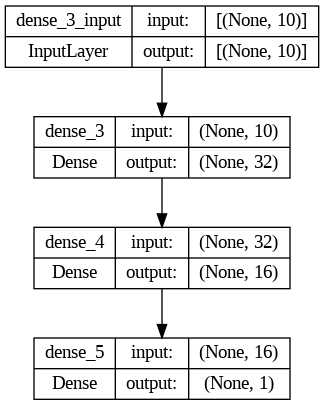

In [127]:
from tensorflow.keras.utils import plot_model

plot_model(classic_model, to_file='classic_model.png', show_shapes=True, show_layer_names=True)



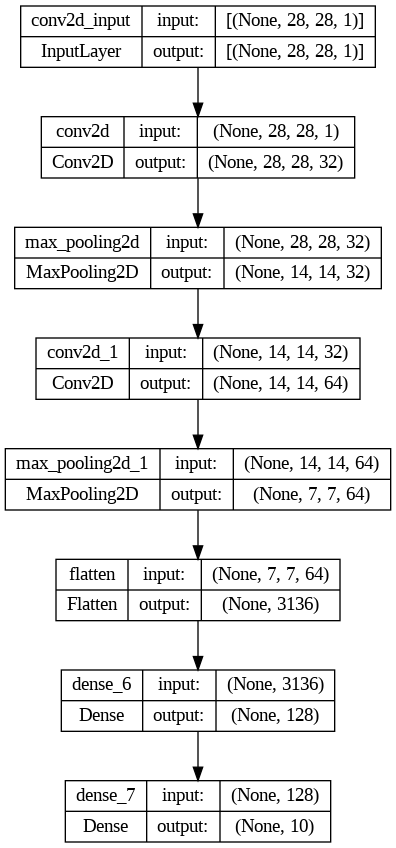

In [129]:
plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

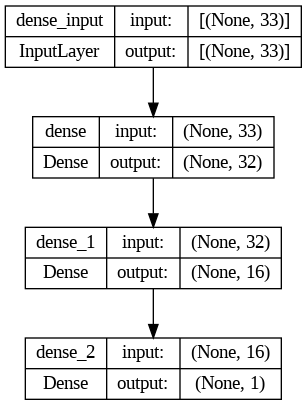

In [130]:
plot_model(pqk_model, to_file='pqk_model.png', show_shapes=True, show_layer_names=True)